Origonal Paper: https://www.nature.com/articles/s41567-020-0932-7

For Reference (state reconstruction and more): https://pennylane.ai/qml/demos/tutorial_classical_shadows/

For Reference (estimating observables): https://pennylane.ai/qml/demos/tutorial_diffable_shadows/

Import Modules

In [75]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler

Constructing the Classical Shadow

In [76]:
def construct_shadow (circuit, shadow_size, num_qubits):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a quantum circuit, this function creates a collection of bitstrings generated by random single-qubit Pauli measurements and records the associated random pauli measurment.

    Args:
        circuit (QuantumCircuit): The quantum circuit which resulting state we wish to estimate.
        shadow_size (int): The number of random Pauli measurements to be taken.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.array: An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.
    """

    # Array to store the classical shadow.
    shadow = np.zeros((shadow_size, num_qubits), dtype=object)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # Create a quantum and classical registers for the circuit.
    qr = QuantumRegister(num_qubits, 'q')
    cr = ClassicalRegister(1, 'c')

    # Iterate over the number of shadows.
    for i in range(shadow_size):

        # Iterate over all the qubits in the circuit.
        for j in range(num_qubits):

            # Randomly select a unitary from the ensemble.
            unitary_index = np.random.randint(0,3)
            unitary = unitary_ensemble[unitary_index]

            # Apply the unitary to the qubit and measure in the computational basis.

            # The circuit below will apply the unitary to qubit j and measure it in the computational basis.
            qc = QuantumCircuit(qr, cr)
            qc.append(UnitaryGate(unitary, "Rand_Pauli"), [j])
            qc.measure(j, 0)

            # Compose the measurment circuit with the input circuit.
            qc = circuit.compose(qc)

            # Instantiate a sampler that runs the cicuit once.
            sampler = StatevectorSampler(default_shots = 1)     
            # Run the sampler on the quantum circuit and store the result.
            result = sampler.run([qc]).result()[0]              

            # Store the counts for number of 0's and 1's measured in the computational basis.
            counts = result.data.c.get_counts()       

            # Get the measured basis state.
            if '0' in counts.keys():
                b = 0
            else:
                b = 1

            # Record the result of the measurement and the unitary applied.
            shadow[i,j] = (b, unitary_index)

    return shadow

State Reconstruction using a Classical Shadow

In [77]:
def reconstruct_from_shadow(shadow):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a classical shadow, this function reconstructs an approximation of the density matrix of the quantum state.
    
    Args:
        shadow (np.array): An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.

    Returns:
        np.array: An approximation of the density matrix of the quantum state.
    """

    # Size of the shadow and Number of qubits in the circuit.
    shadow_size, num_qubits = shadow.shape

    # Computational basis states.
    zero_state = np.matrix([[1,0],[0,0]], dtype=complex)
    one_state = np.matrix([[0,0],[0,1]], dtype=complex)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # For a multiqubit state we must apply the formula S44 from the preskill paper.

    # Array to store the estimated density matrix.
    rho_estimated = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    for i in shadow:
        # Array to store the density matrix at each snapshot.
        rho_snapshot = [1]

        for j in i:
            
            # Implementation of formula S44 from the preskill paper.
            U = unitary_ensemble[j[1]]
            if j[0] == 0:
                b_state = zero_state
            else:
                b_state = one_state

            rho_local = 3*(U.H @ b_state @ U) - identity

            rho_snapshot = np.kron(rho_local, rho_snapshot)

        # Average all the inverted basis states to get an approximation of the density matrix.

        rho_estimated += rho_snapshot

    return rho_estimated/shadow_size

Testing the reconstruction routine

In [78]:
def operator_distance(A, B):
    """
    Calculate the distance between two operators using the frobenius norm.

    Args:
        A (np.array): The first operator.
        B (np.array): The second operator.

    Returns:
        float: The distance between the two operators.
    """

    return np.linalg.norm((A - B), ord = 'fro')

Test the reconstruction with a single qubit state.

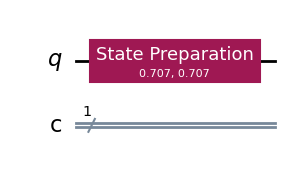

In [79]:
single_qubit_state = [1/np.sqrt(2), 1/np.sqrt(2)]

# Instantiate quantum and classical registers each of 1 bit.
single_qubit_qr = QuantumRegister (1, 'q')
single_qubit_cr = ClassicalRegister(1, 'c')

# Create a quantum circuit and add the prepare_state function acting on qubit 0.
single_qubit_qc = QuantumCircuit(single_qubit_qr, single_qubit_cr)
single_qubit_qc.prepare_state(state = single_qubit_state, qubits = 0)

# Draw the ciruit in mpl (matplotlib).
single_qubit_qc.draw("mpl")

In [95]:
shadow = construct_shadow(single_qubit_qc, 100, 1)

rho_estimated = reconstruct_from_shadow(shadow)
print(np.round(rho_estimated, decimals = 4))

phi = np.matrix(single_qubit_state).T

rho_expected = phi @ phi.H
print(rho_expected)

print(operator_distance(rho_estimated, rho_expected))

[[0.44 +0.j    0.525+0.045j]
 [0.525-0.045j 0.56 +0.j   ]]
[[0.5 0.5]
 [0.5 0.5]]
0.11180339887498945


Test with a trivial 2 qubit state

[0 0 1 0]


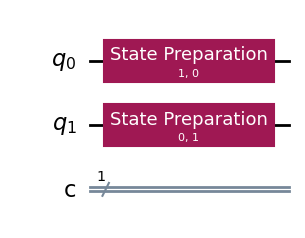

In [81]:
trivial_2_qubit_state = [0, 0, 1, 0]

test = np.kron([0,1], [1,0])
print(test)

# Instantiate quantum register of 2 bits and classical register of 1 bit.
trivial_2_qubit_qr = QuantumRegister(2, 'q')
trivial_2_qubit_cr = ClassicalRegister(1, 'c')

# Create a quantum circuit and add the prepare_state function acting on qubits 0 and 1.
trivial_2_qubit_qc = QuantumCircuit(trivial_2_qubit_qr, trivial_2_qubit_cr)
trivial_2_qubit_qc.prepare_state(state = [1,0], qubits=0)
trivial_2_qubit_qc.prepare_state(state = [0,1], qubits=1)

# Draw the circuit in mpl (matplotlib).
trivial_2_qubit_qc.draw('mpl')

#Note: Qiskit is little endian so a 3 qubit tensor product is ordered as |q2> |q1> |q0>. Therefore preparing qubit 0 in state 0 and qubit 1 in state 1 give the tensor product state |10> = |1> |0>.


In [94]:
shadow = construct_shadow(trivial_2_qubit_qc, 100, 2)

rho_estimated = reconstruct_from_shadow(shadow)
print(np.round(rho_estimated, decimals = 4))

phi = np.matrix(trivial_2_qubit_state).T

rho_expected = phi @ phi.H
print(rho_expected)

print(operator_distance(rho_estimated, rho_expected))

# Note the swapped entries. Between the rho_estimated and rho_expected. The 0.97 in the rho_estimaed should be where the 1 is in the rho_expected. Fixed this by changing the order of the tensor product in the end of the reconstruct_from_shadow function.

[[-0.005+0.j    -0.09 -0.09j   0.075+0.105j  0.09 +0.225j]
 [-0.09 +0.09j  -0.02 +0.j     0.   +0.225j -0.06 -0.075j]
 [ 0.075-0.105j  0.   -0.225j  0.97 +0.j     0.18 +0.045j]
 [ 0.09 -0.225j -0.06 +0.075j  0.18 -0.045j  0.055+0.j   ]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]]
0.613229157819489


Test with a 2 qubit state (bell state)

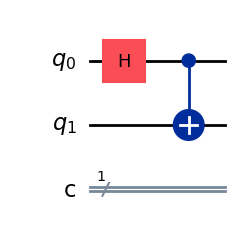

In [83]:
bell_state = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]

# Instantiate quantum register of 2 bits and classical register of 1 bit.
bell_state_qr = QuantumRegister (2, 'q')
bell_state_cr = ClassicalRegister(1, 'c')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr, bell_state_cr)
bell_state_qc.append(
    HGate(),
    [0]
)
bell_state_qc.append(
    CXGate(),
    [0, 1]
)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [96]:
shadow = construct_shadow(bell_state_qc, 1000, 2)

rho_estimated = reconstruct_from_shadow(shadow)
print(np.round(rho_estimated, decimals = 4))

phi = np.matrix(bell_state).T

rho_expected = phi @ phi.H
print(rho_expected)

print(operator_distance(rho_estimated, rho_expected))

# There is still clearly an issue here. The estimated density matrix is not close to the expected density matrix even when using a relatively large shadow. Did swapping the arguments in np.kron in the reconstruct_from_shadow function cause further issues or did it bring me closer to a solution? I will investigate this further. I don't need to fix this as I belive the construction of the classical shadow is correct. I will investigate the reconstruction of the density matrix after implementing the observable estimatior.


[[ 0.2298+0.j      0.0495-0.0187j -0.0315+0.0233j -0.0562+0.0135j]
 [ 0.0495+0.0187j  0.2237+0.j      0.0022-0.0315j  0.0135+0.0053j]
 [-0.0315-0.0233j  0.0022+0.0315j  0.2762+0.j     -0.0315+0.0037j]
 [-0.0562-0.0135j  0.0135-0.0053j -0.0315-0.0037j  0.2702+0.j    ]]
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]
0.9404716901640366


Estimating Pauli Observables (using median of means estimation). In the example on the pennylane site there is a key requirment for the observables. They must be decomposed into a sequence of tensor products of pauli operators (including the identity). 

In [85]:
def estimate_linear_observable(shadow, observable, k = 10):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/ and the origonal paper by Preskill.

    Given a classical shadow, an observable and value k, this function estimates the expectation value of the observable using median of means on k estimators.s

    Args:
        shadow (np.array): An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.
        observable (np.array): The observable to be estimated.
        k (int): The number of subsets to split the shadow into. The number of estimators.

    Returns:
        float: The estimated expectation value of the observable.
    """

    # Size of the shadow and Number of qubits in the circuit.
    shadow_size, num_qubits = shadow.shape

    # Split the shadow into k subsets.
    shadows = np.array_split(shadow, k)

    # Array to store the estimated expectation values from each estimator.
    means = np.zeros(k)

    # Iterate over the number of estimators. Calculate the expectation value of the observable for each estimator and store the result in the means array.
    for i in shadows:
        for j in i:
            
            
    # Return the median of the means.
    return np.median(means)



It is instructive to know how many samples are required to bound the error of our estimator by $\epsilon$ for a given set of observables. The following is an implementation of S13 in https://www.nature.com/articles/s41567-020-0932-7.

In [86]:
def shadow_bound(error, observables, failure_rate = 0.01):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    
    """

Compare the number of samples for error $\epsilon$ and compare it to the variance for the naive appoach of obtaining the expectation value of each observable by means of repeated projective measurements in the eigen basis of the observable. (I think this is the correct wording)